# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 24.11.2021

Мягкий дедлайн: 23:59MSK 04.12.2021

Жесткий дедлайн: 23:59MSK 10.12.2021

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.38524084914798

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [6]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    all_preds = {index: [] for index in np.arange(len(X))}
    for _ in range(num_runs):
        in_bag_indices = np.random.choice(np.arange(len(X)), size=len(X))
        out_of_bag_indices = [index for index in np.arange(len(X)) if index not in in_bag_indices]
        preds = regressor.fit(X[in_bag_indices], y[in_bag_indices]).predict(X[out_of_bag_indices])
        list(map(lambda index: all_preds[out_of_bag_indices[index]].append(preds[index]), np.arange(len(out_of_bag_indices))))

    mean_preds = np.array([np.mean(i[1]) for i in all_preds.items() if i[1]])
    biases = (y[[true for true in all_preds.keys() if all_preds[true]]] - mean_preds) ** 2
    bias = biases.sum() / len(biases)

    variances = np.array([np.var(i[1]) for i in all_preds.items() if i[1]])
    variance = variances.sum() / variances.size

    errors = np.array([((y[p] - m) ** 2).sum() / len(m) for p, m in all_preds.items() if m]) 
    error = errors.sum() / errors.size

    return bias, variance, error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [95]:
from sklearn.linear_model import LinearRegression

bias, variance, error = compute_biase_variance(LinearRegression(), X, y)
print('For linear regression:')
print('   bias is', bias)
print('   variance is', variance)
print('   error is', error)

For linear regression:
   bias is 23.7191701184678
   variance is 0.9291178626000464
   error is 24.64828798106785


In [97]:
from sklearn.tree import DecisionTreeRegressor

bias, variance, error = compute_biase_variance(DecisionTreeRegressor(), X, y)
print('For linear regression:')
print('   bias is', bias)
print('   variance is', variance)
print('   error is', error)

For linear regression:
   bias is 10.222947500301059
   variance is 12.812676480102464
   error is 23.035623980403525


**тут очепяточка!!! decision tree конечно а не linear regression, она была выше**

In [96]:
from sklearn.ensemble import RandomForestRegressor

bias, variance, error = compute_biase_variance(RandomForestRegressor(), X, y)
print('For random forest:')
print('   bias is', bias)
print('   variance is', variance)
print('   error is', error)

For random forest:
   bias is 10.694280313138778
   variance is 2.2503930447715486
   error is 12.944673357910329


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__

Да! 

На занятиях мы обсуждали, что композиция деревьев, обученная беггингом, имеет то же смещение, что и базовые модели, и уменьшает разброс, умноженный на ковариацию базовых моделей, в столько раз, сколько у нас моделей

Случайный лес устроен так, что минимизирует схожесть базовых моделей за счет выбора лучшего признака из их рандомного подмножества в каждой вершине. Видимо, не настолько сильно снижает, чтобы разброс снизился прямо в сто раз (а столько эстиматоров у нас по умолчанию), но смещение действительно осталось примерно то же, а вот разброс стал меньше аж в шесть раз! 

Что касается линейной модели, то логично предположить, что связь между ценой и всеми факторами, на нее влияющими, хоть и имеет линейную природу, но все-таки не в полной мере ею является. Поэтому смещение линейной модели сильно больше, чем то у деревьев: достаточно глубокие деревья (а именно такие строятся с дефолтными гиперпараметрами) могут очень хорошо аппроксимировать практически любую связь признакового описания и таргета. При этом чем глубже дерево, тем сильнее оно зависит от конкретной обучающей выборки, именно поэтому разброс решающего дерева намного больше разброса линейной модели, которая в силу своей простоты каждый раз строится примерно одинаково. 

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

In [108]:
linear_bag = BaggingRegressor(base_estimator=LinearRegression())
linear_bias, linear_variance, linear_error = compute_biase_variance(linear_bag, X, y)
print('For bag of linear models:')
print('   bias is', linear_bias)
print('   variance is', linear_variance)
print('   error is', linear_error)

For bag of linear models:
   bias is 23.69069147467732
   variance is 1.0095049847760222
   error is 24.700196459453345


In [106]:
tree_bag = BaggingRegressor(base_estimator=DecisionTreeRegressor())
tree_bias, tree_variance, tree_error = compute_biase_variance(tree_bag, X, y)
print('For bag of tree models:')
print('   bias is', tree_bias)
print('   variance is', tree_variance)
print('   error is', tree_error)

For bag of tree models:
   bias is 10.60872018260154
   variance is 3.3831876326469743
   error is 13.991907815248513


In [105]:
rf_bag = BaggingRegressor(base_estimator=RandomForestRegressor())
rf_bias, rf_variance, rf_error = compute_biase_variance(rf_bag, X, y)
print('For bag of random forest models:')
print('   bias is', rf_bias)
print('   variance is', rf_variance)
print('   error is', rf_error)

For bag of random forest models:
   bias is 11.619385651299794
   variance is 1.3647491004744763
   error is 12.98413475177427


In [21]:
# простите за хардкодинг просто делала в разные сессии а заново ждать миллион лет не могла себе позволить

to_dataframe = {}
to_dataframe['bias'] = list(map(float, '23.719 10.22 10.694 23.690 10.6 11.619'.split()))
to_dataframe['variance'] = list(map(float, '0.929 12.81 2.25 1.0 3.38 1.364'.split()))
to_dataframe['error'] = list(map(float, '24.648 23.035 12.944 24.7 13.99 12.9841'.split()))

to_dataframe['estimator'] = ['linear', 'tree', 'random_forest'] * 2
to_dataframe['ensemble'] = ['base'] * 3 + ['ensemble'] * 3

pd.DataFrame(to_dataframe)

,bias,variance,error,estimator,ensemble
0,23.719,0.929,24.6480,linear,base
1,10.220,12.810,23.0350,tree,base
2,10.694,2.250,12.9440,random_forest,base
3,23.690,1.000,24.7000,linear,ensemble
4,10.600,3.380,13.9900,tree,ensemble
5,11.619,1.364,12.9841,random_forest,ensemble


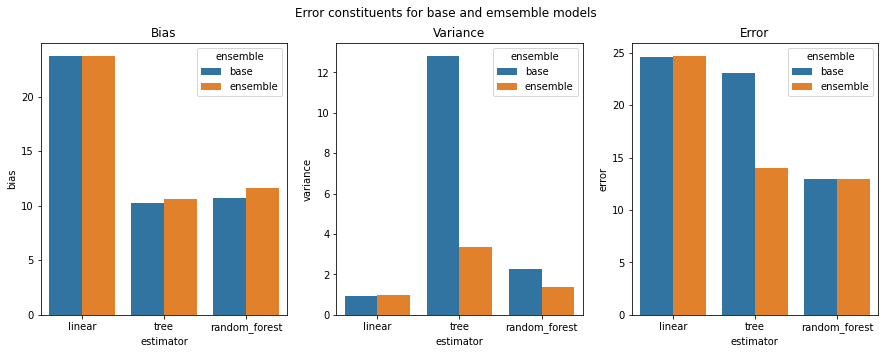

In [27]:
import seaborn as sns
from matplotlib import pyplot as plt


fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
fig.suptitle('Error constituents for base and emsemble models')

sns.barplot(data=pd.DataFrame(to_dataframe), y='bias', x='estimator', hue='ensemble', ax=axes[0])
axes[0].set_title('Bias')

sns.barplot(data=pd.DataFrame(to_dataframe), y='variance', x='estimator', hue='ensemble', ax=axes[1])
axes[1].set_title('Variance')

sns.barplot(data=pd.DataFrame(to_dataframe), y='error', x='estimator', hue='ensemble', ax=axes[2])
axes[2].set_title('Error')

plt.show()



__Your answer here:__

Исходя из теории, композиция моделей, при условии низкого значения их ковариации, должна снижать разброс в столько раз, сколько у нас моделей. 

Что касается линейных моделей, то в их случае снижения разброса не произошло. Это можно связать со спецификой линейной модели: в силу своей простоты она изначально имеет довольно низкий разброс, то есть несильно зависит от небольших изменений в данных. Поэтому, скорее всего, базовые модели похожи друг на друга, и значть имеют выраженную ковариацию, что и привело даже к некоторому увеличению разброса. 

Сильнее всего разброс упал для деревьев: действительно, при дефолтных параметрах деревья получаются достаточно глубокими, а значит несмещенными и с высоким разбросом. Благодаря сильной зависимости от малейших изменений в обучающей выборки, деревья скорее всего вышли не очень похожими, ошибались в разных местах, что и позволило уменьшить их разброс значительно. 

Случайный лес уже является беггинговой композицией над деревьями, в которой и так снижен разброс путем добавления случайности в построение деревьев. Сниженный разброс предполагает, что при изменении обучающей выборки модель будет меняться не слишком сильно. А значит, их ковариация будет иметь отличное от нуля значение. Таким образом при объединении этих моделей в композицию разброс снижается не так сильно, как мог бы в теории, однако все еще сильнее, чем в случае с линейной моделью, ибо разброс ее базовых моделей еще ниже.

Иными словами, снижение разброса при объединении моделей в композицию в некоторой степени пропорционально разбросу самих базовых моделей: чем он больше, чем сильнее будет эффект от объединения.


### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [119]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title="", ax=None):
    """
    plot graphics described above
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test_objects)
    all_preds = {target: [] for target in y_test}
    for _ in range(num_runs):
        in_bag_indices = np.random.choice(np.arange(len(X_train)), size=len(X_train))
        preds = regressor.fit(X_train[in_bag_indices], y_train[in_bag_indices]).predict(X_test)
        list(map(lambda index, target: all_preds[target].append(preds[index]), np.arange(len(y_test)), y_test))
    df = pd.DataFrame({'target': np.array([[target] * len(predictions) for target, predictions in all_preds.items()]).flatten(),
                    'prediction': np.array(list(all_preds.values())).flatten()})
    
    # plt.figure(figsize=(8, 6), dpi=80)
    if not ax:
        ax = sns.scatterplot(data=df, y='prediction', x='target', hue='target', palette='Set2', legend=False)
        plt.title(title)
    else:
        sns.scatterplot(data=df, y='prediction', x='target', hue='target', palette='Set2', legend=False, ax=ax)
        ax.set_title(title)
    sns.scatterplot(x=y_test, y=y_test, color='black', ax=ax)
    return ax

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

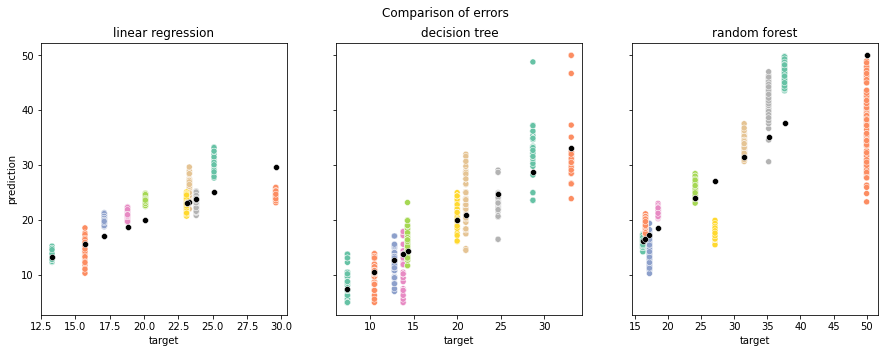

In [123]:
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Comparison of errors')

plot_predictions(LinearRegression(), X, y, title='linear regression', ax=axes[0])
plot_predictions(DecisionTreeRegressor(), X, y, title='decision tree', ax=axes[1])
plot_predictions(RandomForestRegressor(), X, y, title='random forest', ax=axes[2])

plt.show()

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__


Линейная модель довольно часто не угадывает правильное значение: ни одна из обученных моделей не попала в примерно половину представленных таргетов. Это говорит о высоком смещении. Кроме этого, бросается в глаза сконцентрированность предсказаний немного по-разному обученных линейных моделей: они все находятся рядом, их границы довольно четкие и без отклонений от основной массы. Из этого можно заключить, что у линейной модели не очень высокий разброс, так как изменения в обучающей выборке не приводят к драматичному изменению предсказания. 

Решающее дерево зацепило все из представленных таргетов: каждый из тестовых у был угадан хотя бы одним из решающих деревьев. Кроме этого, большая часть правильных ответов находится ближе к центру кластеров предложенных деревьями ответов. Это говорит о низком смещении. С другой стороны, в случае с деревьями выбросов среди данных ответов намного больше, чем было у линейных моделей: кластеры менее четкие и в среднем шире. Это говорит о большем разбросе.

Что касается случайного леса, то здесь неотгаданными остались дв-три таргета из десяти: смещение ниже, чем у линейной модели, но выше, чем у дерева. Что касается самих кластеров, то они достаточно широкие, однако однородные -- выбросов практически нет, что говорит о том, что разброс меньше, чем у одного дерева, но все-таки значительно больше, чем у линейной модели.

Этот анализ частично опровергает теорию: предполагается, что композиция деревьев должна иметь сопоставимое с базовой моделью смещение. Вероятно, 10 таргетов мало для того, чтобы это было очевидным. 


### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

100%|██████████| 13/13 [01:05<00:00,  5.02s/it]


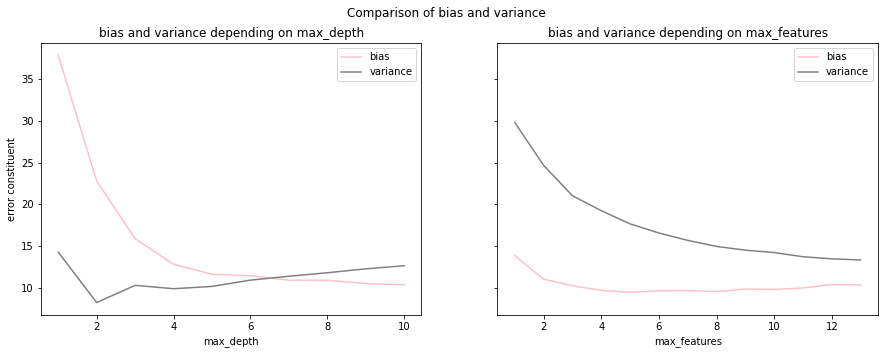

In [140]:
from tqdm import tqdm

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Comparison of bias and variance')

max_depth_grid = np.arange(10) + 1
biases = []
variances = []
for max_depth in tqdm(max_depth_grid):
    bias, variance, _ = compute_biase_variance(DecisionTreeRegressor(max_depth=max_depth), X, y)
    biases.append(bias)
    variances.append(variance)

sns.lineplot(x=max_depth_grid, y=biases, ax=axes[0], color='pink', label='bias')
sns.lineplot(x=max_depth_grid, y=variances, ax=axes[0], color='grey', label='variance')
axes[0].set_title('bias and variance depending on max_depth')
axes[0].set(xlabel='max_depth', ylabel='error constituent')

max_features_grid = np.arange(X.shape[1]) + 1
biases = []
variances = []
for max_features in tqdm(max_features_grid):
    bias, variance, _ = compute_biase_variance(DecisionTreeRegressor(max_features=max_features), X, y)
    biases.append(bias)
    variances.append(variance)

sns.lineplot(x=max_features_grid, y=biases, ax=axes[1], color='pink', label='bias')
sns.lineplot(x=max_features_grid, y=variances, ax=axes[1], color='grey', label='variance')
axes[1].set_title('bias and variance depending on max_features')
axes[1].set(xlabel='max_features', ylabel='error constituent')

plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [144]:
n_estimators_grid = 2**np.arange(1, 10)

results = {'RandomForestRegressor': {}, 'GradientBoosting': {}}

for n_estimators in tqdm(n_estimators_grid):
    bias, variance, _ = compute_biase_variance(RandomForestRegressor(n_estimators=n_estimators), X, y)
    results['RandomForestRegressor'][n_estimators] = {'bias': bias, 'variance': variance}

100%|██████████| 9/9 [59:26<00:00, 396.27s/it]


In [147]:
from sklearn.ensemble import GradientBoostingRegressor

for n_estimators in tqdm(n_estimators_grid):
    bias, variance, _ = compute_biase_variance(GradientBoostingRegressor(n_estimators=n_estimators), X, y)
    results['GradientBoosting'][n_estimators] = {'bias': bias, 'variance': variance}

100%|██████████| 9/9 [22:22<00:00, 149.21s/it]


In [148]:
results

{'GradientBoosting': {2: {'bias': 62.60686227030949,
   'variance': 0.38070808762692915},
  4: {'bias': 47.41157384716215, 'variance': 0.6553420646618433},
  8: {'bias': 29.590491262057938, 'variance': 1.0346686401425598},
  16: {'bias': 16.425032198068294, 'variance': 1.4070389862773893},
  32: {'bias': 11.110653294204887, 'variance': 1.6791752185480269},
  64: {'bias': 9.535383376984981, 'variance': 1.9087176335888971},
  128: {'bias': 8.98274488190421, 'variance': 2.1152674056324177},
  256: {'bias': 8.78498539055858, 'variance': 2.290924241276512},
  512: {'bias': 8.590483048187139, 'variance': 2.4378112009890764}},
 'RandomForestRegressor': {2: {'bias': 10.629696047347084,
   'variance': 8.564882157563506},
  4: {'bias': 10.530381165130038, 'variance': 5.306001904636879},
  8: {'bias': 10.64266733168717, 'variance': 3.6682036133699043},
  16: {'bias': 10.697340256524535, 'variance': 2.8989886152334714},
  32: {'bias': 10.57811571059119, 'variance': 2.5122617586651645},
  64: {'bia

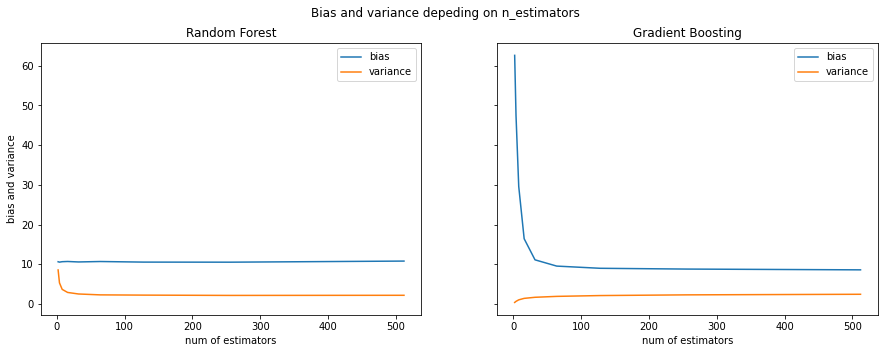

In [161]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Bias and variance depeding on n_estimators')

sns.lineplot(y=[i['bias'] for i in results['RandomForestRegressor'].values()],
             x=n_estimators_grid, 
             label='bias',
             ax=axes[0])

sns.lineplot(y=[i['variance'] for i in results['RandomForestRegressor'].values()],
             x=n_estimators_grid, 
             label='variance',
             ax=axes[0])

axes[0].set_title('Random Forest')
axes[0].set(ylabel='bias and variance', xlabel='num of estimators')

sns.lineplot(y=[i['bias'] for i in results['GradientBoosting'].values()],
             x=n_estimators_grid, 
             label='bias',
             ax=axes[1])

sns.lineplot(y=[i['variance'] for i in results['GradientBoosting'].values()],
             x=n_estimators_grid, 
             label='variance',
             ax=axes[1])
axes[1].set_title('Gradient Boosting')
axes[1].set(ylabel='bias and variance', xlabel='num of estimators')


plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

**max_depth vs bias**

Чем дерево глубже, тем оно несмещеннее: большее количество предикатов позволяет более детально расчертить признаковое пространство.  

**max_depth vs variance**

С другой стороны, большая глубина подразумевает еще и большую склонность к переобучению: появляется вероятность чрезмерного подгона под тестовую выборку. Деревья таким образом получаюся разными в зависимости от даже небольшого изменения в обучающей выборке -- у них сильный разброс. Он линейно зависит от глубины дерева. 

**max_features vs bias**

Чем меньшее количество признаков мы разрешаем рассматривать в каждой вершине, тем сильнее будут отличаться деревья, поскольку они будут опираться на разные признаковые закономерности. При увеличении мощности подмножества рассматриваемых признаков эти подмножества в целом становятся более похожими, что обусловливает пропорционально меньший разброс деревьев в этом случае.

**max_features vs variance**

На смещенность этот параметр влияет меньше, поскольку при неограниченной глубине деревья все еще могут добиться довольно сильной аппроксимации реальной связи. Однако очень сильное уменьшение подмножества значительно увеличивает риск упустить важный признак, что приводит к большей смещенности.

**random forest bias vs n_estimators**

На занятиях было установлено, что смещение композиции деревьев примерно равно смещению базовой модели. Количество деревьев поэтому на данный параметр влияет слабо.

**random forest variance vs n_estimators**

А вот смещение такая композиция способна снизить очень сильно: благодаря рандомизации подмножества рассматриваемых в вершинах признаках базовые модели получаются разные, что позволяет резко снизить их общий разброс. 

Также стоит отметить, что случайный лес не переобучается с ростом количества базовых моделей: это связано с тем, что они обучаются параллельно, а значит независимо друг от друга. 

**gb bias vs n_estimators**

В градиентном бустинге модели обучаются последовательно: каждая следующая при этом обучается на сдвиг -- отличие ответа композиции от таргета. Поэтому прирост количества моделей дает снижение их общего смещения, пока оно не упрется в целом максимально низкое для данной базовой модели. 

**gb variance vs n_estimators**

В отличие от случайного леса, градиентный бустинг может переобучиться при слишком большом количестве базовых моделей: это связано с тем, что в силу последовательного обучения и добавления моделей разброс стабильно, хоть и не очень резко, растет, и он, в отличие от смещения, не упирается в какое-то значение. Это несильно видно в данном графике из-за несопоставимых изменений смещения и разброса, но в словаре ячейкой выше тенденцию легко обнаружить. 

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

In [162]:
from IPython.display import Image
Image(url='https://media.giphy.com/media/uuocoePH1mkVy/giphy.gif')